In [122]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split

In [123]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [124]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.01
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias 

# If they where numpy arrays
#x_tensor = torch.from_numpy(x).float()
#y_tensor = torch.from_numpy(y).float()


In [125]:
class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

#dataset = TensorDataset(X, y) 
dataset = CustomDataset(X, y)

train_dataset, val_dataset = random_split(dataset, [80, 20])
print(train_dataset[0])
train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

(tensor([0.2600]), tensor([0.4820]))


In [126]:
X_train = torch.from_numpy(np.array([train_dataset[i][0].numpy() for i in range(len(train_dataset)) ]))
y_train = torch.from_numpy(np.array([train_dataset[i][1].numpy() for i in range(len(train_dataset)) ]))

X_val = torch.from_numpy(np.array([val_dataset[i][0].numpy() for i in range(len(val_dataset)) ]))
y_val = torch.from_numpy(np.array([val_dataset[i][1].numpy() for i in range(len(val_dataset)) ]))

In [127]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_val, 
                     test_labels=y_val, 
                     predictions=None):
  


  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 5))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="orange", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="g", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

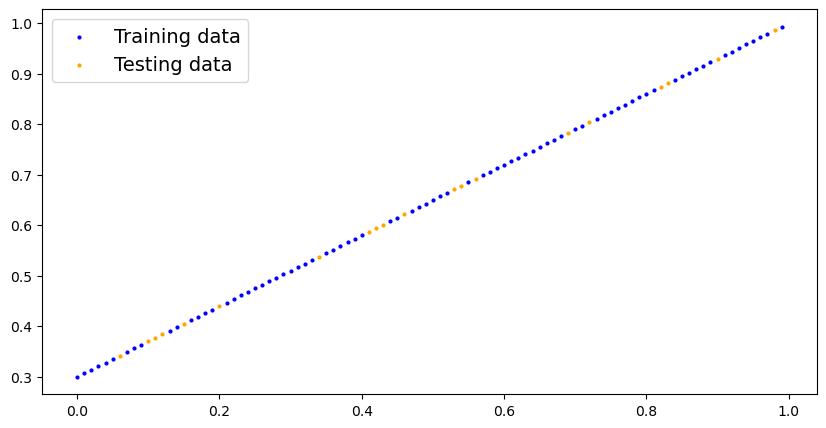

In [128]:
plot_predictions();

#### Building a PyTorch linear model

In [129]:
# Create a Linear Regression model class
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor)-> torch.Tensor:
        return self.linear(x)

#### Training function

In [130]:
def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):

        # Put model in training mode (this is the default state of a model)
        model.train()

        # 1. Forward pass on train data using the forward() method inside
        yhat = model(x)

        # 2. Calculate the loss (how different are our models predictions to the ground truth)
        loss = loss_fn(y, yhat)

        # 3. Zero grad of the optimizer
        optimizer.zero_grad()

        # 4. Loss backwards
        loss.backward()

        # 5. Progress the optimizer
        optimizer.step()
        
        return loss.item()
    return train_step

#### Training Loop

In [131]:
# Estimate a and b
torch.manual_seed(42)

model = ManualLinearRegression().to(device) # model = nn.Sequential(nn.Linear(1, 1)).to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=1e-1)
train_step = make_train_step(model, loss_fn, optimizer)

n_epochs = 100
training_losses = []
validation_losses = []
print(model.state_dict())

for epoch in range(n_epochs):
    batch_losses = []
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        loss = train_step(x_batch, y_batch)
        batch_losses.append(loss)
    training_loss = np.mean(batch_losses)
    training_losses.append(training_loss)

    with torch.inference_mode():
        val_losses = []
        for x_val, y_val in val_loader:
            # Make sure the data is in the same device as the model
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            model.eval()

            # 1. Forward pass on test data
            yhat = model(x_val)

            # 2. Caculate loss on test data
            val_loss = loss_fn(y_val, yhat).item()
            val_losses.append(val_loss)
            
        validation_loss = np.mean(val_losses)
        validation_losses.append(validation_loss)

    print(f"[{epoch+1}] Training loss: {training_loss:.3f}\t Validation loss: {validation_loss:.3f}")

print(model.state_dict())

OrderedDict([('linear.weight', tensor([[0.7645]])), ('linear.bias', tensor([0.8300]))])
[1] Training loss: 0.137	 Validation loss: 0.020
[2] Training loss: 0.009	 Validation loss: 0.003
[3] Training loss: 0.002	 Validation loss: 0.002
[4] Training loss: 0.002	 Validation loss: 0.001
[5] Training loss: 0.001	 Validation loss: 0.001
[6] Training loss: 0.001	 Validation loss: 0.001
[7] Training loss: 0.001	 Validation loss: 0.001
[8] Training loss: 0.001	 Validation loss: 0.001
[9] Training loss: 0.001	 Validation loss: 0.001
[10] Training loss: 0.001	 Validation loss: 0.001
[11] Training loss: 0.001	 Validation loss: 0.001
[12] Training loss: 0.001	 Validation loss: 0.000
[13] Training loss: 0.000	 Validation loss: 0.000
[14] Training loss: 0.000	 Validation loss: 0.000
[15] Training loss: 0.000	 Validation loss: 0.000
[16] Training loss: 0.000	 Validation loss: 0.000
[17] Training loss: 0.000	 Validation loss: 0.000
[18] Training loss: 0.000	 Validation loss: 0.000
[19] Training loss: 0

100 100


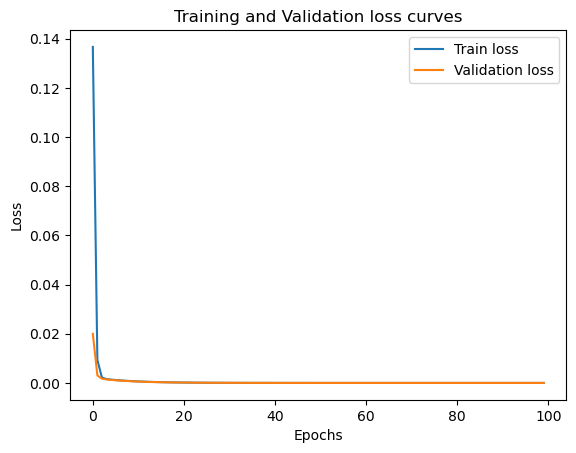

In [132]:
# Plot the loss curves
epoch_count = [i for i in range(n_epochs)]
print(len(training_losses),len(validation_losses))
plt.plot(epoch_count, training_losses, label="Train loss")
plt.plot(epoch_count, validation_losses, label="Validation loss")
plt.title("Training and Validation loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

#### Making predictions

In [133]:
# 1. Set the model in evaluation mode
model.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model(X_val)
y_preds

tensor([[0.5380],
        [0.3771],
        [0.7830],
        [0.3421],
        [0.8739],
        [0.6780],
        [0.9859],
        [0.6010],
        [0.8040],
        [0.4051],
        [0.5940],
        [0.4401],
        [0.6920],
        [0.3701],
        [0.6220],
        [0.3841],
        [0.6710],
        [0.9299],
        [0.5870],
        [0.8809]])

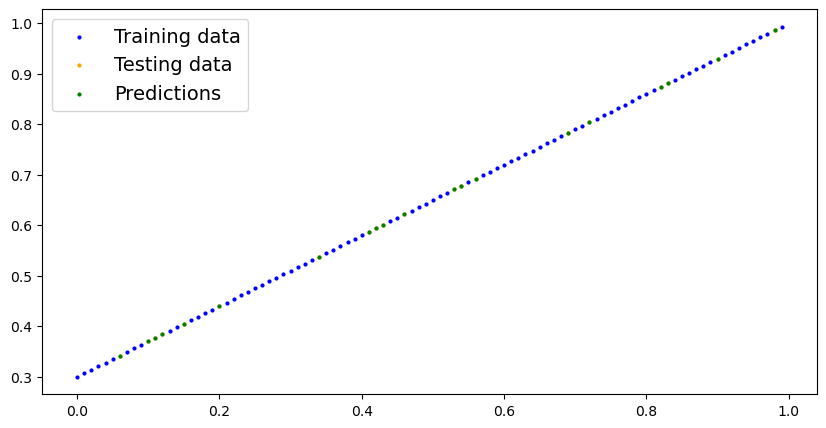

In [134]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU

# Put data on the CPU and plot it
plot_predictions(predictions=y_preds.cpu())

#### Saving and loading a model

In [135]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models\01_pytorch_workflow_model.pth


In [136]:
# 1. Create a new instance of the LinearRegressionModelV2() class
# 2. Load in the model state dict using torch.nn.Module.load_state_dict()
# 3. Send the new instance of the model to the target device (to ensure our code is device-agnostic)


# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model = ManualLinearRegression()

# Load model state dict 
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model.to(device)

print(f"Loaded model:\n{loaded_model}")
print(f"Model on device : {next( loaded_model.parameters()).device}")

Loaded model:
ManualLinearRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
Model on device : cpu


In [137]:
# Evaluate loaded model
loaded_model.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model(X_val)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])